# MLP model

The problem with the bigram models built in the previous notebook, [Bigram](https://github.com/danielsimon4/language-modeling/blob/main/Bigram.ipynb), is that the predictions were not very good because we only took one character of context. In this notebook, we are going to implement a **multi-layer perceptron model (MLP) character level language model** to predict the next character in a sequence.

## Bengio et al. (2003). A neural probabilistic language model

The modeling approach that we are going to adopt follows the paper [Bengio et al. (2003). *A neural probabilistic language model*](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf). In this paper, they have a vocabulary of 17,000 possible words, and they instead build a word level language model. We are going to instead build a character level language model but the modeling approach will be the same to the one in the paper. 

<br>

**Embedding space:**

They propose to associate to each word of the 17,000 words a 30 dimensional feature vector. Thus, **every word is embedded** into a 30 dimensional space. At the beginning these words are **initialized completely randomly**. Then, we are going to **tune these embeddings** of these words using back propagation so during the course of training of this neural network these 17,000 vectors are going to **move around** in this 30 dimensional space. Synonyms or words that have very similar meanings might end up in a very similar part of the space and conversely words that mean very different things would go somewhere else in a space.

<img src="https://www.researchgate.net/publication/351461645/figure/fig1/AS:1022001976209408@1620675667870/Example-2D-word-embedding-space-where-similar-words-are-closer-together.ppm" alt="image" width="600"/>

The **advantage** of this modeling approach is that suppose that the model is trying to predict:

*A dog was running in a _____*. 

But the model has never encountered this exact phrase in the training set so it is out of distribution. This approach gets around with this problem because maybe the model has seen similar phrases during training:

*The dog was running in the room*

And maybe the model has learned that "a" and "the" are frequently interchangeable with each other because their embeddings are nearby in the space. Thus, we can transfer knowledge and generalize to know scenarios through the **embedding space**.

<br>

**Digram of the neural network:**

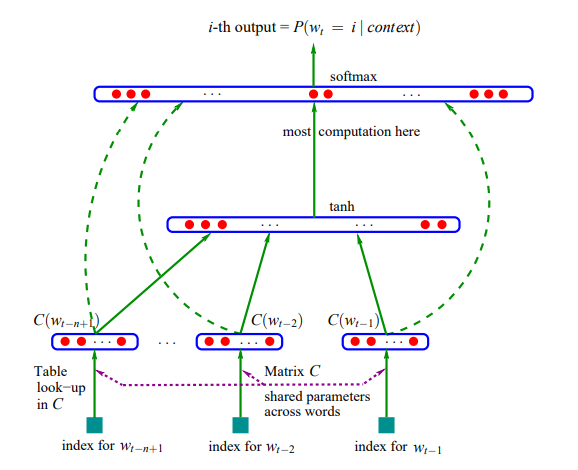

Starting from the bottom, they are taking three previous words and they are trying to predict the fourth word in a sequence. The three previous words have an index between 0 and 16999 (because we have a vocabulary of 17,000 words). The 17,000 x 30 matrix `C` serves as a lookup table so every index is plucking out a row of this **embedding matrix** so we get the 30 dimensional vector that corresponds to the **embedding vector** for that word.


- First, we have an **input layer** of 30 neurons for three words making up 90 neurons in total. 
- Next, we have a **hidden layer** fully conected to the 90 neurons input layer. The size of this hidden layer is a hyperparameter (design choice up to the designer of the neural net).
- Finally, we have an **output layer** of 17,000 neurons fully connected to the neurons in the hidden layer. On top, we have a **softmax layer** so that instead of logits we get a nice probability distribution for the next word in the sequence.

During training we have the identity of the next word in the sequence. Its index is used to pluck out the probability of that word and then we are maximizing the probability of that word with respect to the parameters of the neural net using backpropagation.

## Libraries

In [415]:
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt 
%matplotlib inline

## Load and explore dataset

In [416]:
with open('names.txt', 'r') as file:
    words = file.read().splitlines()

In [417]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [418]:
len(words)

32033

## Mappinng of characters to/from integers

The elements of the list `words` are strings (which are groups of characters). Thus, we need to build the vocabulary of characters and mappings to/from integers.

In [419]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

# Reduced dataset (32 examples)

## Build the dataset

- `block_size` is the context length: *How many characters do we take to predict the next one?*
- The list `X` contains the input examples to the neural net.
- The list `Y` contains the labels for each example inside X.
- The list `context` is initialized with `block_size` number of zeros. `Context` will keep track of the previous characters (up to `block_size`).
- *context = context[1:] + [ix]* updates the context by removing the first element and appending the current character's index `ix` to the end.

In [420]:
block_size = 3
X, Y = [], []

for w in words[:5]:
  
  print(w)
  context = [0] * block_size

  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [421]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1],
        [ 0,  0,  0],
        [ 0,  0,  9],
        [ 0,  9, 19],
        [ 9, 19,  1],
        [19,  1,  2],
        [ 1,  2,  5],
        [ 2,  5, 12],
        [ 5, 12, 12],
        [12, 12,  1],
        [ 0,  0,  0],
        [ 0,  0, 19],
        [ 0, 19, 15],
        [19, 15, 16],
        [15, 16,  8],
        [16,  8,  9],
        [ 8,  9,  1]])

In [422]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

Thus, we have 32 examples to train our neural net:

In [423]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

## Embedding lookup table

In the paper, they have 17,000 words and they embed them in a 30 dimensional space. In our case, we have only 27 possible characters and we are going to embed them in a smaller 2 dimensional space. The lookup table `C` will  have 27 rows and 2 columns and will be initialized with random numbers. 

In [424]:
C = torch.randn((27, 2))
C

tensor([[-1.1089, -1.5825],
        [-1.4513,  0.0181],
        [-1.4837,  0.5286],
        [-0.3414, -0.7488],
        [-0.4110,  0.7466],
        [ 0.6833, -0.2536],
        [-1.7987, -2.4711],
        [-1.0831, -0.7216],
        [ 0.2990, -0.5725],
        [-0.7489, -0.6123],
        [-0.3913, -0.1438],
        [-0.3324,  0.8786],
        [ 1.8198, -0.0125],
        [-0.3461,  1.2817],
        [-0.2428,  0.7572],
        [ 0.4760, -0.5645],
        [ 1.3182, -0.1269],
        [-0.9042, -0.2740],
        [ 0.6727,  0.1780],
        [-0.4687,  0.3078],
        [-1.4892, -0.7019],
        [ 1.2214, -0.1985],
        [ 0.9522,  1.7980],
        [-0.2113, -1.2517],
        [-0.1416, -1.1549],
        [-0.4500,  1.3486],
        [ 0.7618,  3.3206]])

## Input layer

To embed a single individual integer, like 5, we can just index into row five of the matrix `C` and get the vector in the fifth row.

In [425]:
C[5]

tensor([ 0.6833, -0.2536])

Another way is to one-hot encode the integer 5 so we get a 27 dimensional vector of all zeros except the fifth dimension with a 1. Then, we can mulitply the one-hot encoded vector with the matrix `C` and will get the same result as before.

In [426]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([ 0.6833, -0.2536])

We will use indexing, the first approach, because it is faster. PyTorch can also index multidimensional tensors like `X` which had shape 32 by 3. Thus, we will get the tensor `emb` which contains the **embedding vector** for each integer in the tensor `X`.

In [427]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

## Hidden layer

The weights and bias of the hidden layer will be initialized randomly. The number of inputs is 6 (3 x 2) because we have 2 dimensional embeddings and we have 3 of them. The number of neurons is 100.

Matrix multiplication will not work because the tensor `emb` has shape 32 by 3 by 2 and the tensor `W1` has shape 6 by 100. We can use the extremly efficient PyTorch operation `view` to flatten the tensor `emb` so it has shape 32 by 6.

**Note:** *emb.view(32, 6)* is equivalent to *emb.view(emb.shape[0], 6)* or *emb.view(-1, 6)* 

In [428]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h.shape

torch.Size([32, 100])

## Output layer

The weights and bias of the output layer will be initialized randomly. The number of inputs is 100. The number of neurons is 27 because we have 27 posible characters that come next.

In [429]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

## Softmax and loss

**Note:** *torch.arange(228146)* creates the follwing tensor: 

*tensor([     0,      1,      2,  ..., 228143, 228144, 228145])*. 

This serves to iterate the rows.

In [430]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(17.1764)

The ***cross_entropy* function** in PyTorch performs the previous steps more efficently:

In [431]:
loss = F.cross_entropy(logits, Y)
loss

tensor(17.1764)

## Neural net (all together)

In [432]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
  p.requires_grad = True

Number of parameters in total:

In [433]:
sum(p.nelement() for p in parameters)

3481

In [434]:
for _ in range(1000):
  
  # forward pass
  emb = C[X] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Y)
  print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  for p in parameters:
    p.data += -0.1 * p.grad

17.769712448120117
13.656402587890625
11.298768997192383
9.452457427978516
7.984262466430664
6.891321182250977
6.1000142097473145
5.452036380767822
4.898151874542236
4.414664268493652
3.985849142074585
3.6028308868408203
3.262141704559326
2.961381196975708
2.6982972621917725
2.469712972640991
2.271660804748535
2.101283550262451
1.9571771621704102
1.8374855518341064
1.7380964756011963
1.6535117626190186
1.579089879989624
1.5117664337158203
1.449604868888855
1.3913120031356812
1.3359923362731934
1.283052682876587
1.2321912050247192
1.18338143825531
1.1367988586425781
1.092664361000061
1.0510926246643066
1.0120269060134888
0.9752706289291382
0.9405567049980164
0.9076126217842102
0.8761922717094421
0.8460891246795654
0.8171356916427612
0.78919917345047
0.7621746063232422
0.7359814047813416
0.7105579972267151
0.6858610510826111
0.6618654131889343
0.638565719127655
0.6159819960594177
0.5941659808158875
0.573210597038269
0.5532563328742981
0.5344882011413574
0.5171167850494385
0.5013313293457

**Note:** We get a very low loss because our neural net of 3,481 parameters is **overfitting** the 32 examples from the first five words.

# Full dataset (228,146 examples)

## Build the dataset

In [435]:
block_size = 3

X, Y = [], []
for w in words:
  
  context = [0] * block_size

  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    context = context[1:] + [ix]
  
X = torch.tensor(X)
Y = torch.tensor(Y)

Now we have 228,146 examples to train our neural net:

In [436]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

## Neural net

In [437]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
  p.requires_grad = True

In [438]:
for _ in range(10):
  
  # forward pass
  emb = C[X] # (228146, 3, 2)
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (228146, 100)
  logits = h @ W2 + b2 # (228146, 27)
  loss = F.cross_entropy(logits, Y)
  print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  for p in parameters:
    p.data += -0.1 * p.grad

19.505229949951172
17.084484100341797
15.776532173156738
14.833341598510742
14.002605438232422
13.253263473510742
12.57991886138916
11.983102798461914
11.47049331665039
11.05185604095459


## Mini-batches

It takes quite a bit of time for every single iteration to complete because we are doing too much work forwarding and backwarding 228,146 examples. We can perform forward and backward pass and update on **mini-batches** of the data. We will randomly select some portion of the data set (a mini-batch) and only forward, backward and update on that little mini-batch.

*ix = torch.randint(0, X.shape[0], (32,))* randomly generates 32 integers between 0 and Xtr.shape[0] that index into our dataset.


This way we can run **many examples** nearly instantly and decrease the loss **much faster**. Because we are only dealing with mini-batches the quality of our gradient is
lower (it is not the actual gradient direction) but the gradient direction is good enough even when it is estimating on only 32 examples. Thus, it is better to evaluate an approximate gradient, and just make more faster steps, than evaluate the exact gradient, and take fewer lower steps.

In [439]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
  p.requires_grad = True

In [440]:
for i in range(1000):
  
  # mini-batch construct
  ix = torch.randint(0, X.shape[0], (32,))
  
  # forward pass
  emb = C[X[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Y[ix])
  print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  for p in parameters:
    p.data += -0.1 * p.grad

20.96575355529785
15.737205505371094
15.547405242919922
14.004457473754883
13.381732940673828
12.645030975341797
13.301140785217285
12.0746431350708
11.680838584899902
13.597041130065918
8.992477416992188
11.443184852600098
10.996271133422852
10.463939666748047
9.948554992675781
9.994348526000977
6.966425895690918
9.192307472229004
8.784402847290039
8.216668128967285
10.080007553100586
7.074251174926758
10.079851150512695
8.32325553894043
7.51962947845459
5.862676620483398
5.376498222351074
7.744834899902344
7.120220184326172
6.019204616546631
8.201610565185547
4.553946018218994
6.597815990447998
6.772580146789551
5.72241735458374
5.594975471496582
7.306993007659912
5.574130058288574
6.193233489990234
6.023066520690918
6.3699951171875
5.229977130889893
7.475804805755615
6.0929975509643555
6.069163799285889
6.420648574829102
6.170139312744141
6.087451457977295
4.926988124847412
6.130959987640381
5.1521501541137695
5.54520845413208
3.547483444213867
6.217108249664307
6.238231182098389
4.

The loss we see is the loss of each batch. The loss of the whole dataset is:

In [441]:
emb = C[X] # (228146, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (228146, 100)
logits = h @ W2 + b2 # (228146, 27)
loss = F.cross_entropy(logits, Y)
loss

tensor(2.7395, grad_fn=<NllLossBackward0>)

## Learning rate

*How did we determined the 0.1 learing rate?*

We have to first find a proper range

- If we try with -0.0001 the loss barely decreases.
- If we try with -0.001 the loss slowly decreases (lower range).
- If we try with -10 the loss does not decrease.
- If we try with -1 the loss unstably decreases (higher range).

Thus, the right learning rate is between -0.001 and -1.

*torch.linespace(-3, 0, 1000)* creates a 1,000 numbers between -3 and 1 so we are stepping linearly between the learning rate exponents (`lre`). Since the learning rate speed (`lrs`) is *10^lre*, we are stepping exponentialy between the learning rate from -0.001 to -1.


In [442]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [443]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
  p.requires_grad = True

In [444]:
lrei = []
lossi = []

for i in range(1000):
  
  # mini-batch construct
  ix = torch.randint(0, X.shape[0], (32,))
  
  # forward pass
  emb = C[X[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Y[ix])
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = lrs[i]
  for p in parameters:
    p.data += -lr * p.grad
  
  # track stats
  lrei.append(lre[i])
  lossi.append(loss.item())

We can see that an exponent of the learning rate that is good to use is -1. Thus, -0.1 is a good learning rate:

Text(0, 0.5, 'Loss')

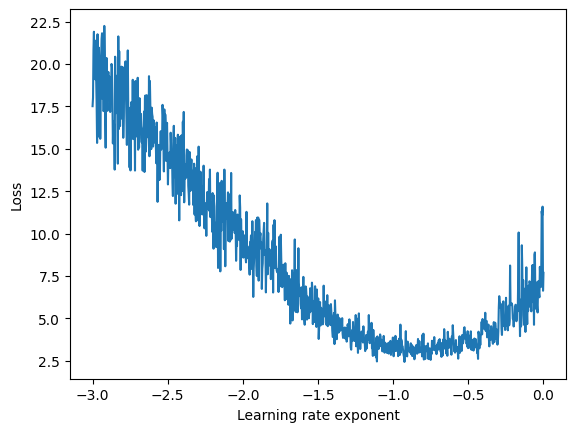

In [445]:
plt.plot(lrei, lossi)
plt.xlabel('Learning rate exponent')
plt.ylabel('Loss')

## Learning rate decay

A **learning rate decay** is a common practice that consists on lowering the learning rate at the late stages of training.

In [446]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
  p.requires_grad = True

In [447]:
for i in range(40000):
  
  # mini-batch construct
  ix = torch.randint(0, X.shape[0], (32,))
  
  # forward pass
  emb = C[X[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Y[ix])
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 30000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

In [448]:
emb = C[X] # (228146, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (228146, 100)
logits = h @ W2 + b2 # (228146, 27)
loss = F.cross_entropy(logits, Y)
loss

tensor(2.3435, grad_fn=<NllLossBackward0>)

# Splitting the dataset

In order to avoid overfitting, we split our dataset into a training  split, a dev split (or validation slit), and a test split.

- The **training split** (80% of the dataset) is used to optimize the parameters of the model.
- The **dev or validation split** (10% of the dataset) is used for development over all the hyper parameters of the model so hyperparameters (size of the hidden layer, size of the embedding, strength of the regularization, ...)
- The **test split** is used to evaluate the performance of the model at the end (this is where we evaluate the loss only a few times so we avoid overfitting the test loss).

## Build the dataset

In [449]:
block_size = 3

def build_dataset(words):  

  X, Y = [], []
  
  for w in words:
    
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [450]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
  p.requires_grad = True

In [451]:
for i in range(40000):
  
  # mini-batch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 30000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

Train loss:

In [452]:
emb = C[Xtr] # (182580, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (182580, 100)
logits = h @ W2 + b2 # (182580, 27)
loss = F.cross_entropy(logits, Ytr)
print('Train loss:', loss.item())

Train loss: 2.341787099838257


Dev loss:

In [453]:
emb = C[Xdev] # (22767, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (22767, 100)
logits = h @ W2 + b2 # (22767, 27)
loss = F.cross_entropy(logits, Ydev)
print('dev loss:', loss.item())

dev loss: 2.3399126529693604


# Increasing neural net

The train loss and dev loss are roughly equal so we are not overfitting. In fact, we are underfitting because the model is not powerful enough to just be purely memorizing the data. That typically means that our network is very small and we expect to make performance improvements by scaling up the size of this neural net.

In [454]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
  p.requires_grad = True

In [455]:
sum(p.nelement() for p in parameters)

10281

In [456]:
stepi = []
lossi = []

for i in range(40000):
  
  # mini-batch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 300)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 30000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad
  
  # track stats
  stepi.append(i)
  lossi.append(loss.item())

**Note:** The mini-batches are the ones that create a little bit of noise.

Text(0, 0.5, 'Loss')

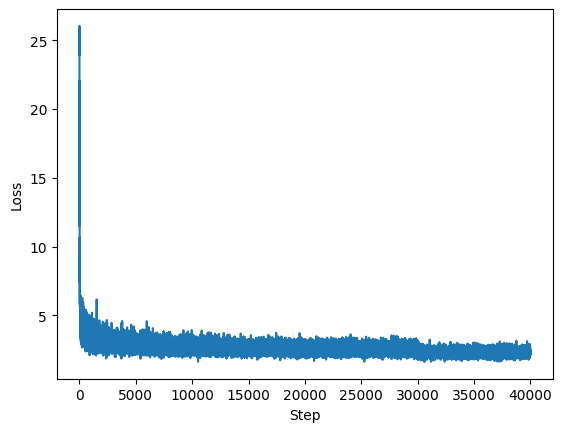

In [457]:
plt.plot(stepi, lossi)
plt.xlabel('Step')
plt.ylabel('Loss')

In [458]:
emb = C[Xtr] # (182580, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (182580, 300)
logits = h @ W2 + b2 # (182580, 27)
loss = F.cross_entropy(logits, Ytr)
print('Train loss:', loss.item())

Train loss: 2.311497688293457


In [459]:
emb = C[Xdev] # (22767, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (22767, 300)
logits = h @ W2 + b2 # (22767, 27)
loss = F.cross_entropy(logits, Ydev)
print('dev loss:', loss.item())

dev loss: 2.3158645629882812


# Increasing embedding size

We are not improving much more. Maybe the bottleneck is the **character embedding size** which is 2.

We can visualize the embeddings that were trained by the neural net on these characters as the embedding size is only 2. The x and y coordinates are the columns of the embbeding matrix `C`.

As we can see, the network has learned to **separate out the characters** and cluster them. That tells us that the neural net treats those character as very similar (and kind of interchangeable) because their embedding is very similar.

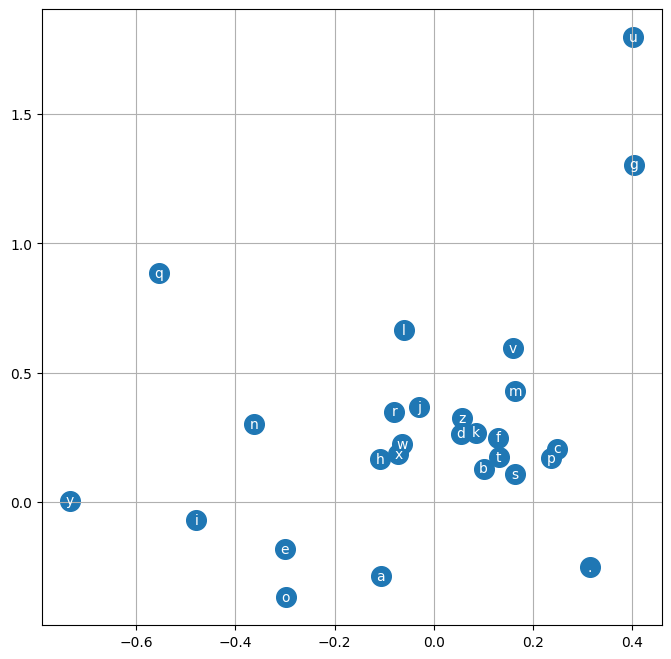

In [460]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

We are going to increase the 2 dimensional embeddings to 10 dimensional embeddings.

In [461]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
  p.requires_grad = True

In [462]:
sum(p.nelement() for p in parameters)

11897

In [463]:
stepi = []
lossi = []

for i in range(200000):
  
  # mini-batch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad
  
  # track stats
  stepi.append(i)
  lossi.append(loss.log10().item())

**Note:** Log loss squashes vertically the loss so it looks nicer.

Text(0, 0.5, 'Log Loss')

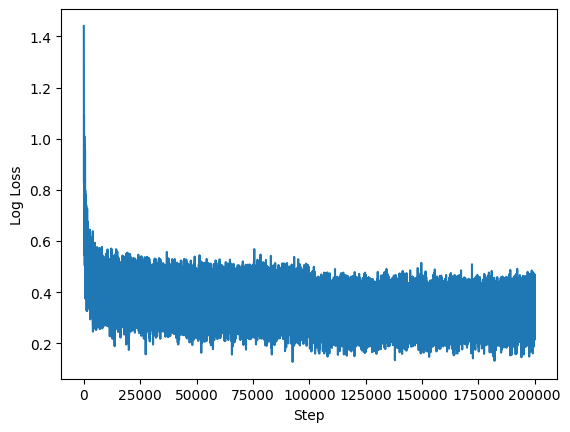

In [464]:
plt.plot(stepi, lossi)
plt.xlabel('Step')
plt.ylabel('Log Loss')

In [465]:
emb = C[Xtr] # (182580, 3, 10)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (182580, 200)
logits = h @ W2 + b2 # (182580, 27)
loss = F.cross_entropy(logits, Ytr)
print('Train loss:', loss.item())

Train loss: 2.1457557678222656


In [466]:
emb = C[Xdev] # (22767, 3, 10)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (22767, 200)
logits = h @ W2 + b2 # (22767, 27)
loss = F.cross_entropy(logits, Ydev)
print('dev loss:', loss.item())

dev loss: 2.1817994117736816


The train and dev loss are starting to differ so maybe the number of parameters is large enough that we are starting to overfit.

In [467]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [469]:
emb = C[Xte] # (22767, 3, 10)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (22767, 200)
logits = h @ W2 + b2 # (22767, 27)
loss = F.cross_entropy(logits, Yte)
print('Test loss:', loss.item())

Test loss: 2.1787421703338623


# Sample from the model

**Note:** Until we generate the dot character, we are going to embed the currrent context:

*emb = C[torch.tensor([context])]*

**Note:** *F.softmax(logits, dim=1)* exponentiates the logits and makes them sum to one.

In [468]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...

    while True:
      emb = C[torch.tensor([context])] # (1, 3, 10)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)

      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

mora.
gryan.
see.
mad.
ryah.
rethanthagrargelderedielin.
shi.
jean.
keiseso.
nartelyn.
maltea.
noshubergia.
miel.
kin.
reelyn.
job.
adanu.
zayven.
jamell.
eli.
